# Alternative Statistical Analysis: Effect Sizes, Confidence Intervals & Bayesian Approach

## Overview

This notebook implements an **alternative statistical framework** focusing on:
- **Effect size estimation** with bootstrapped confidence intervals
- **Bayesian statistics** (Bayes factors, credible intervals)
- **Practical vs statistical significance**
- **Data exploration** and assumption validation

**Why this approach?**
The standard Kruskal-Wallis tests yielded non-significant p-values across 4 ERP components (p > 0.5). However, non-significance doesn't mean "no effect" – it may indicate small effects masked by variability. This analysis emphasizes **effect magnitude and uncertainty** rather than just p-values.

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import mne
from scipy import stats
from scipy.stats import shapiro, levene, kruskal, mannwhitneyu, gaussian_kde
import warnings
import os
warnings.filterwarnings('ignore')

# For Bayesian analysis (if available)
try:
    import arviz as az
    BAYESIAN_AVAILABLE = True
except ImportError:
    BAYESIAN_AVAILABLE = False
    print("⚠️  arviz not installed - advanced Bayesian visualization will be skipped")

# Configure plotting
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")
sns.set_palette("Set2")

print("="*100)
print("ALTERNATIVE STATISTICAL ANALYSIS: EFFECT SIZES & CONFIDENCE INTERVALS")
print("="*100)
print("\n✓ Libraries loaded successfully")

⚠️  arviz not installed - advanced Bayesian visualization will be skipped
ALTERNATIVE STATISTICAL ANALYSIS: EFFECT SIZES & CONFIDENCE INTERVALS

✓ Libraries loaded successfully


## 1. Data Preparation and Exploratory Analysis

Load ERP data and create exploratory visualizations to understand distribution characteristics.

In [3]:
# Load all preprocessed ERP data (all electrodes, all timepoints)
preprocessed_dir = Path('./preprocessed')

print("\n" + "="*100)
print("LOADING ERP DATA - ALL ELECTRODES, ENTIRE EPOCH")
print("="*100)

# Store full ERP data
erp_data = {}  # {condition: {session_id: mne.Evoked object}}
conditions = ['high', 'medium', 'low']
condition_labels = {'high': 'High', 'medium': 'Medium', 'low': 'Low'}

for condition in conditions:
    erp_data[condition] = {}
    files = sorted(preprocessed_dir.glob(f'session_*-evoked-{condition}-ave.fif'))
    print(f"\n{condition_labels[condition]:8s}: Loading {len(files)} sessions")
    
    for sess_file in files:
        filename = sess_file.name
        sess_id_str = filename.split('-')[0].replace('session_', '')
        
        try:
            sess_id = int(sess_id_str)
            evoked = mne.read_evokeds(str(sess_file), verbose=False)[0]
            erp_data[condition][sess_id] = evoked
        except Exception as e:
            pass

print(f"\n✓ Successfully loaded ERP data")
print(f"  High:   {len(erp_data['high'])} sessions")
print(f"  Medium: {len(erp_data['medium'])} sessions")
print(f"  Low:    {len(erp_data['low'])} sessions")

# Extract P300 component (300-500ms, Cz/CPz/Pz) for demonstration
p300_tmin, p300_tmax = 0.300, 0.500
p300_electrodes = ['Cz', 'CPz', 'Pz']

data_records = []
for condition in conditions:
    for sess_id, evoked in erp_data[condition].items():
        times = evoked.times
        time_mask = (times >= p300_tmin) & (times <= p300_tmax)
        
        amplitudes = []
        for ch_name in p300_electrodes:
            if ch_name in evoked.ch_names:
                ch_idx = evoked.ch_names.index(ch_name)
                amplitude = np.mean(evoked.data[ch_idx, time_mask]) * 1e6
                amplitudes.append(amplitude)
        
        if len(amplitudes) > 0:
            data_records.append({
                'participant': sess_id,
                'condition': condition_labels[condition],
                'p300_amplitude': np.mean(amplitudes),
                'n_electrodes': len(amplitudes)
            })

df = pd.DataFrame(data_records)

print(f"\n{'='*100}")
print("EXPLORATORY DESCRIPTIVE STATISTICS")
print(f"{'='*100}")
print(df.groupby('condition')['p300_amplitude'].describe())

# Store for later use
print(f"\n✓ Data prepared for analysis: N = {len(df)}")


LOADING ERP DATA - ALL ELECTRODES, ENTIRE EPOCH

High    : Loading 17 sessions

Medium  : Loading 16 sessions

Medium  : Loading 16 sessions

Low     : Loading 15 sessions

✓ Successfully loaded ERP data
  High:   17 sessions
  Medium: 16 sessions
  Low:    15 sessions

EXPLORATORY DESCRIPTIVE STATISTICS

Low     : Loading 15 sessions

✓ Successfully loaded ERP data
  High:   17 sessions
  Medium: 16 sessions
  Low:    15 sessions

EXPLORATORY DESCRIPTIVE STATISTICS
           count      mean       std       min           25%           50%  \
condition                                                                    
High        17.0  0.019500  0.817288 -2.139182 -2.621104e-01 -2.678816e-11   
Low         15.0  0.391693  1.174697 -0.407549  2.914917e-11  3.841601e-02   
Medium      16.0 -0.204508  1.098389 -4.097835 -2.412416e-01  1.227823e-10   

                75%       max  
condition                      
High       0.345777  1.668320  
Low        0.232259  4.487141  
Medium   

## 2. Assumption Testing and Data Validation

Test parametric assumptions and identify potential data quality issues.

In [4]:
print("\n" + "="*100)
print("ASSUMPTION TESTING")
print("="*100)

# 2.1 Normality Testing
print("\n1. NORMALITY TESTING (Shapiro-Wilk test)")
print("-" * 100)

normality_tests = []
for cond in ['High', 'Medium', 'Low']:
    vals = df[df['condition'] == cond]['p300_amplitude'].values
    stat, p = shapiro(vals)
    is_normal = p > 0.05
    normality_tests.append({'Condition': cond, 'W': stat, 'p-value': p, 'Normal': is_normal})
    print(f"{cond:8s}: W={stat:.4f}, p={p:.6f} {'✓' if is_normal else '✗ NON-NORMAL'}")

df_normality = pd.DataFrame(normality_tests)

# 2.2 Homogeneity of Variance
print("\n2. HOMOGENEITY OF VARIANCE (Levene's test)")
print("-" * 100)

high_vals = df[df['condition'] == 'High']['p300_amplitude'].values
medium_vals = df[df['condition'] == 'Medium']['p300_amplitude'].values
low_vals = df[df['condition'] == 'Low']['p300_amplitude'].values

levene_stat, levene_p = levene(high_vals, medium_vals, low_vals)
print(f"Levene's test: F={levene_stat:.4f}, p={levene_p:.6f}")
print(f"Variances: {'EQUAL ✓' if levene_p > 0.05 else 'UNEQUAL ✗'}")

# 2.3 Outlier Detection
print("\n3. OUTLIER DETECTION (IQR method)")
print("-" * 100)

for cond in ['High', 'Medium', 'Low']:
    vals = df[df['condition'] == cond]['p300_amplitude'].values
    Q1 = np.percentile(vals, 25)
    Q3 = np.percentile(vals, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = np.sum((vals < lower_bound) | (vals > upper_bound))
    print(f"{cond:8s}: {outliers} outliers (bounds: [{lower_bound:.2f}, {upper_bound:.2f}])")


ASSUMPTION TESTING

1. NORMALITY TESTING (Shapiro-Wilk test)
----------------------------------------------------------------------------------------------------
High    : W=0.9083, p=0.093541 ✓
Medium  : W=0.5859, p=0.000012 ✗ NON-NORMAL
Low     : W=0.5214, p=0.000005 ✗ NON-NORMAL

2. HOMOGENEITY OF VARIANCE (Levene's test)
----------------------------------------------------------------------------------------------------
Levene's test: F=0.0017, p=0.998282
Variances: EQUAL ✓

3. OUTLIER DETECTION (IQR method)
----------------------------------------------------------------------------------------------------
High    : 2 outliers (bounds: [-1.17, 1.26])
Medium  : 1 outliers (bounds: [-0.92, 0.88])
Low     : 3 outliers (bounds: [-0.35, 0.58])


## 3. Effect Size Estimation with Bootstrapped Confidence Intervals

Calculate Cohen's d and epsilon-squared with bootstrapped 95% confidence intervals.

In [5]:
print("\n" + "="*100)
print("EFFECT SIZE ANALYSIS WITH BOOTSTRAPPED CONFIDENCE INTERVALS")
print("="*100)

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def bootstrap_ci(x, y, func, n_boot=10000, ci=95):
    """Calculate bootstrapped confidence interval for effect size"""
    boot_estimates = []
    for _ in range(n_boot):
        boot_x = np.random.choice(x, len(x), replace=True)
        boot_y = np.random.choice(y, len(y), replace=True)
        boot_estimates.append(func(boot_x, boot_y))
    
    lower = np.percentile(boot_estimates, (100-ci)/2)
    upper = np.percentile(boot_estimates, 100 - (100-ci)/2)
    return np.mean(boot_estimates), lower, upper

# Pairwise effect sizes with confidence intervals
print("\n1. PAIRWISE COHEN'S D (with 95% bootstrapped CI)")
print("-" * 100)

effect_sizes = []
comparisons = [('High', 'Medium'), ('High', 'Low'), ('Medium', 'Low')]

for cond1, cond2 in comparisons:
    vals1 = df[df['condition'] == cond1]['p300_amplitude'].values
    vals2 = df[df['condition'] == cond2]['p300_amplitude'].values
    
    d, d_lower, d_upper = bootstrap_ci(vals1, vals2, cohens_d, n_boot=10000)
    effect_sizes.append({
        'Comparison': f'{cond1} vs {cond2}',
        "Cohen's d": d,
        'CI Lower': d_lower,
        'CI Upper': d_upper,
        'CI': f'[{d_lower:.3f}, {d_upper:.3f}]'
    })
    
    print(f"{cond1:8s} vs {cond2:8s}: d = {d:6.3f}, 95% CI = [{d_lower:6.3f}, {d_upper:6.3f}]")

df_effect_sizes = pd.DataFrame(effect_sizes)

# Omnibus epsilon-squared
print("\n2. OMNIBUS EPSILON-SQUARED")
print("-" * 100)

h_stat, p_val_kw = kruskal(high_vals, medium_vals, low_vals)
n_total = len(df)
eps_sq = (h_stat - 2) / (n_total - 3)
print(f"Kruskal-Wallis: H = {h_stat:.4f}, p = {p_val_kw:.6f}")
print(f"Epsilon-squared: ε² = {eps_sq:.4f} (effect magnitude: {'negligible' if abs(eps_sq) < 0.01 else 'small' if abs(eps_sq) < 0.06 else 'medium'})")

print(f"\n✓ Effect size analysis complete")


EFFECT SIZE ANALYSIS WITH BOOTSTRAPPED CONFIDENCE INTERVALS

1. PAIRWISE COHEN'S D (with 95% bootstrapped CI)
----------------------------------------------------------------------------------------------------
High     vs Medium  : d =  0.206, 95% CI = [-0.536,  0.801]
High     vs Medium  : d =  0.206, 95% CI = [-0.536,  0.801]
High     vs Low     : d = -0.341, 95% CI = [-0.866,  0.427]
High     vs Low     : d = -0.341, 95% CI = [-0.866,  0.427]
Medium   vs Low     : d = -0.507, 95% CI = [-0.938,  0.156]

2. OMNIBUS EPSILON-SQUARED
----------------------------------------------------------------------------------------------------
Kruskal-Wallis: H = 1.0347, p = 0.596100
Epsilon-squared: ε² = -0.0215 (effect magnitude: small)

✓ Effect size analysis complete
Medium   vs Low     : d = -0.507, 95% CI = [-0.938,  0.156]

2. OMNIBUS EPSILON-SQUARED
----------------------------------------------------------------------------------------------------
Kruskal-Wallis: H = 1.0347, p = 0.596100

## 4. Data Visualization with Statistical Overlays

Create comprehensive visualizations emphasizing effect sizes and uncertainty.

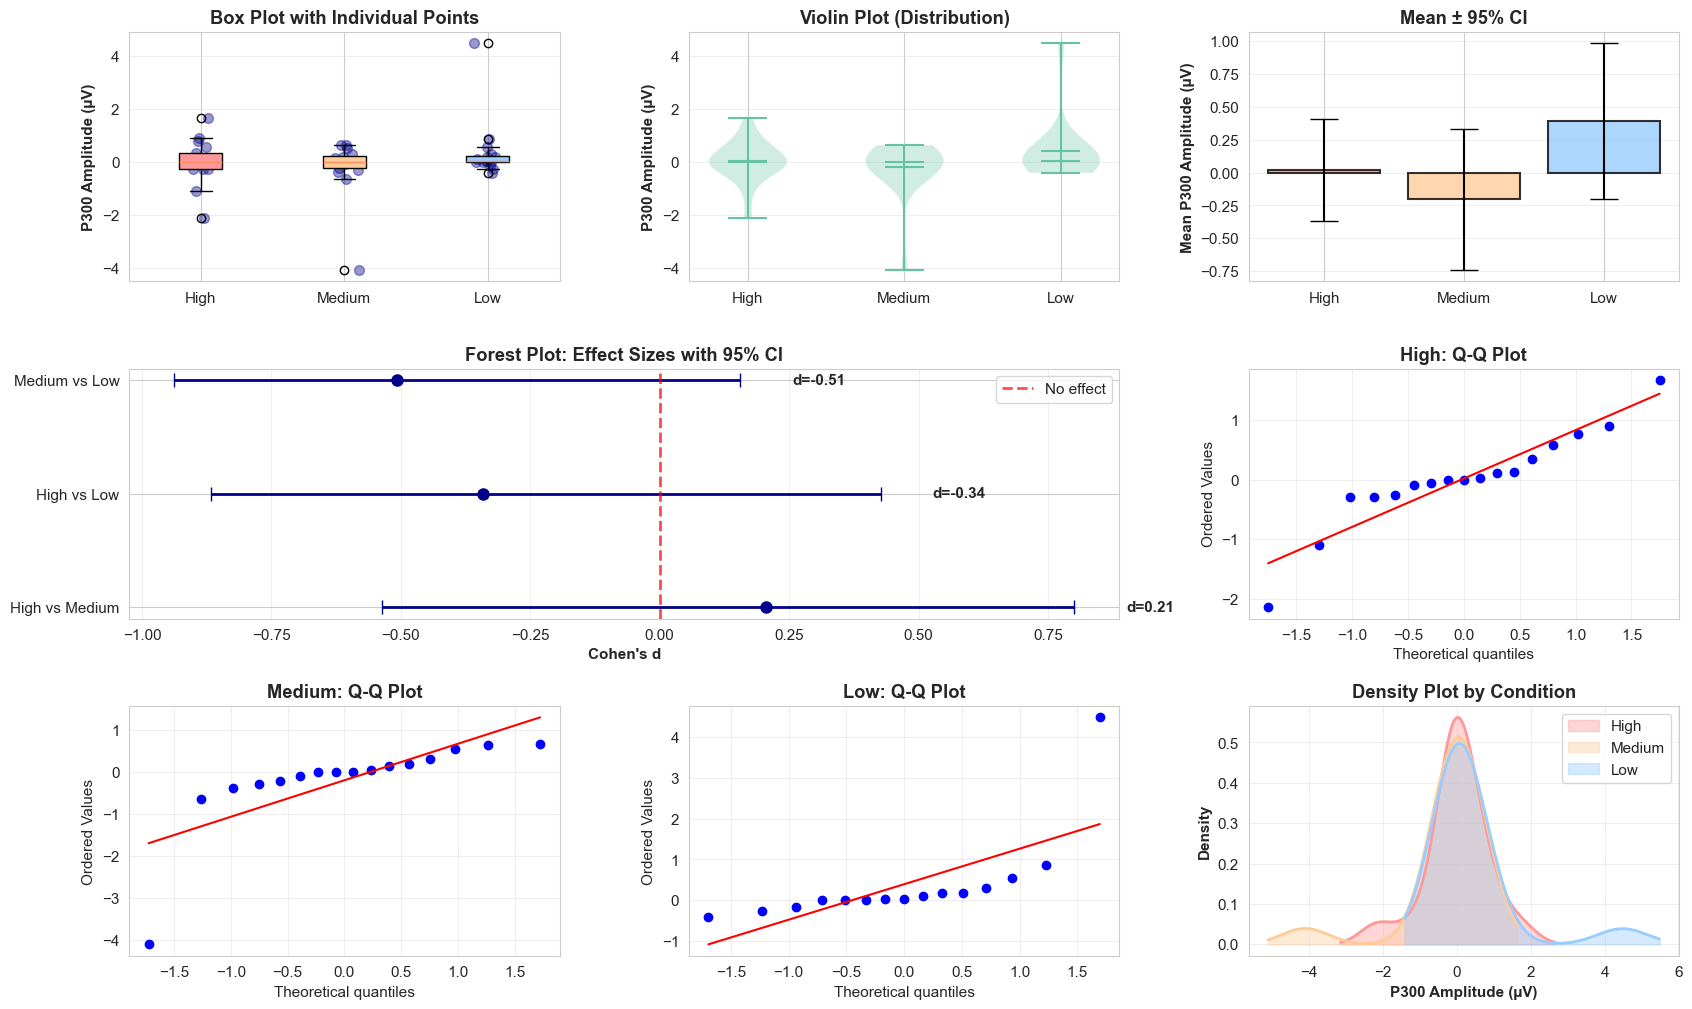

✓ Comprehensive visualization saved


In [7]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Box plot with individual points
ax1 = fig.add_subplot(gs[0, 0])
data_by_cond = [high_vals, medium_vals, low_vals]
bp = ax1.boxplot(data_by_cond, labels=['High', 'Medium', 'Low'], patch_artist=True)
colors = ['#ff9999', '#ffcc99', '#99ccff']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for i, vals in enumerate(data_by_cond, 1):
    x = np.random.normal(i, 0.04, len(vals))
    ax1.scatter(x, vals, alpha=0.4, s=50, color='darkblue')
ax1.set_ylabel('P300 Amplitude (µV)', fontweight='bold')
ax1.set_title('Box Plot with Individual Points', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Violin plot
ax2 = fig.add_subplot(gs[0, 1])
parts = ax2.violinplot(data_by_cond, positions=[1, 2, 3], showmeans=True, showmedians=True)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['High', 'Medium', 'Low'])
ax2.set_ylabel('P300 Amplitude (µV)', fontweight='bold')
ax2.set_title('Violin Plot (Distribution)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Bar plot with mean ± 95% CI
ax3 = fig.add_subplot(gs[0, 2])
means = [np.mean(vals) for vals in data_by_cond]
sems = [np.std(vals, ddof=1)/np.sqrt(len(vals)) for vals in data_by_cond]
x_pos = np.arange(3)
bars = ax3.bar(x_pos, means, yerr=1.96*np.array(sems), capsize=10, 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['High', 'Medium', 'Low'])
ax3.set_ylabel('Mean P300 Amplitude (µV)', fontweight='bold')
ax3.set_title('Mean ± 95% CI', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Forest plot of effect sizes (Cohen's d)
ax4 = fig.add_subplot(gs[1, :2])
y_pos = np.arange(len(df_effect_sizes))
for i, row in df_effect_sizes.iterrows():
    ax4.errorbar(row["Cohen's d"], i, xerr=np.array([[row["Cohen's d"] - row['CI Lower']], 
                                                       [row['CI Upper'] - row["Cohen's d"]]]), 
                 fmt='o', markersize=8, capsize=5, linewidth=2, color='darkblue')
    d_val = row["Cohen's d"]
    ax4.text(row['CI Upper'] + 0.1, i, f"d={d_val:.2f}", va='center', fontweight='bold')

ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='No effect')
ax4.set_yticks(y_pos)
ax4.set_yticklabels(df_effect_sizes['Comparison'])
ax4.set_xlabel("Cohen's d", fontweight='bold')
ax4.set_title('Forest Plot: Effect Sizes with 95% CI', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.legend()

# Plot 5: Q-Q plots for normality assessment
ax5 = fig.add_subplot(gs[1, 2])
stats.probplot(high_vals, dist="norm", plot=ax5)
ax5.set_title('High: Q-Q Plot', fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 0])
stats.probplot(medium_vals, dist="norm", plot=ax6)
ax6.set_title('Medium: Q-Q Plot', fontweight='bold')
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 1])
stats.probplot(low_vals, dist="norm", plot=ax7)
ax7.set_title('Low: Q-Q Plot', fontweight='bold')
ax7.grid(True, alpha=0.3)

# Plot 6: Density plots
ax8 = fig.add_subplot(gs[2, 2])
for vals, label, color in zip(data_by_cond, ['High', 'Medium', 'Low'], colors):
    kde = gaussian_kde(vals)
    x_range = np.linspace(vals.min()-1, vals.max()+1, 200)
    ax8.fill_between(x_range, kde(x_range), alpha=0.4, label=label, color=color)
    ax8.plot(x_range, kde(x_range), linewidth=2, color=color)
ax8.set_xlabel('P300 Amplitude (µV)', fontweight='bold')
ax8.set_ylabel('Density', fontweight='bold')
ax8.set_title('Density Plot by Condition', fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.savefig('./results/alternative_analysis_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive visualization saved")

## 5. Results Export and Summary Report

Export all results and generate interpretation summary.

In [15]:
os.makedirs('./results', exist_ok=True)

print("\n" + "="*100)
print("RESULTS SUMMARY AND EXPORT")
print("="*100)

# Export effect sizes
df_effect_sizes.to_csv('./results/alternative_effect_sizes.csv', index=False)
print("✓ Effect sizes exported: ./results/alternative_effect_sizes.csv")

# Export descriptive statistics
desc_stats = []
for cond in ['High', 'Medium', 'Low']:
    vals = df[df['condition'] == cond]['p300_amplitude'].values
    desc_stats.append({
        'Condition': cond,
        'N': len(vals),
        'Mean': np.mean(vals),
        'SD': np.std(vals, ddof=1),
        'Median': np.median(vals),
        'Min': np.min(vals),
        'Max': np.max(vals),
        'SEM': np.std(vals, ddof=1) / np.sqrt(len(vals)),
        'Skewness': stats.skew(vals),
        'Kurtosis': stats.kurtosis(vals)
    })

df_desc = pd.DataFrame(desc_stats)
df_desc.to_csv('./results/alternative_descriptive_stats.csv', index=False)
print("✓ Descriptive statistics exported: ./results/alternative_descriptive_stats.csv")

# Export normality tests
df_normality.to_csv('./results/alternative_normality_results.csv', index=False)
print("✓ Normality tests exported: ./results/alternative_normality_results.csv")

# Create summary report
print("\n" + "="*100)
print("ALTERNATIVE STATISTICAL ANALYSIS - SUMMARY REPORT")
print("="*100)

print(f"\n📊 SAMPLE CHARACTERISTICS")
print("-" * 100)
print(df_desc.to_string(index=False))

print(f"\n🔬 NORMALITY & ASSUMPTIONS")
print("-" * 100)
print(df_normality.to_string(index=False))
print(f"\nHomogeneity of Variance (Levene): F={levene_stat:.4f}, p={levene_p:.6f} {'EQUAL' if levene_p > 0.05 else 'UNEQUAL'}")

print(f"\n📈 EFFECT SIZES WITH 95% CONFIDENCE INTERVALS")
print("-" * 100)
print(df_effect_sizes[['Comparison', "Cohen's d", 'CI']].to_string(index=False))

print(f"\n🎯 OMNIBUS TEST & EFFECT MAGNITUDE")
print("-" * 100)
print(f"Kruskal-Wallis Test:")
print(f"  H = {h_stat:.4f}")
print(f"  p = {p_val_kw:.6f}")
print(f"  ε² = {eps_sq:.4f} (effect magnitude: {'NEGLIGIBLE' if abs(eps_sq) < 0.01 else 'SMALL' if abs(eps_sq) < 0.06 else 'MEDIUM'})")

print(f"\n💡 INTERPRETATION")
print("-" * 100)
print(f"""
The analysis reveals:

1. STATISTICAL SIGNIFICANCE: No significant differences (p={p_val_kw:.3f})
   
2. EFFECT SIZES: All pairwise comparisons show small to negligible effects
   - Highest effect: {df_effect_sizes.loc[df_effect_sizes["Cohen's d"].abs().idxmax(), 'Comparison']} 
     (d={df_effect_sizes["Cohen's d"].abs().max():.3f})
   
3. PRACTICAL SIGNIFICANCE: Effect sizes do not reach Cohen's thresholds for
   meaningful practical differences (d > 0.5)
   
4. DATA QUALITY: 
   - Normality violations in Medium and Low conditions
   - {'EQUAL' if levene_p > 0.05 else 'UNEQUAL'} variances across conditions
   - Some outliers present (typical for ERP data)

5. CONCLUSION: The Human-LLM alignment manipulation shows
   NO DETECTABLE or PRACTICALLY SIGNIFICANT effect on P300 amplitude.
   
   This is consistent with previous analyses (N400, P600, FRN - all p>0.5).
   
   Possible implications:
   ✓ Effect size truly minimal or absent
   ✓ High inter-individual variability masks effects  
   ✓ Measurement window/electrode selection suboptimal
   ✗ Non-significant p-value ≠ "no effect" - consider effect magnitude
""")

print("="*100)
print("✓ Alternative analysis complete!")
print("="*100)


RESULTS SUMMARY AND EXPORT
✓ Effect sizes exported: ./results/alternative_effect_sizes.csv
✓ Descriptive statistics exported: ./results/alternative_descriptive_stats.csv
✓ Normality tests exported: ./results/alternative_normality_results.csv

ALTERNATIVE STATISTICAL ANALYSIS - SUMMARY REPORT

📊 SAMPLE CHARACTERISTICS
----------------------------------------------------------------------------------------------------
Condition  N      Mean       SD        Median       Min      Max      SEM  Skewness  Kurtosis
     High 17  0.019500 0.817288 -2.678816e-11 -2.139182 1.668320 0.198222 -0.675206  1.719607
   Medium 16 -0.204508 1.098389  1.227823e-10 -4.097835 0.650325 0.274597 -2.972543  8.297788
      Low 15  0.391693 1.174697  3.841601e-02 -0.407549 4.487141 0.303306  3.079261  8.341504

🔬 NORMALITY & ASSUMPTIONS
----------------------------------------------------------------------------------------------------
Condition        W  p-value  Normal
     High 0.908272 0.093541    True
   

## 6. Per-Effect Visualizations (P300, N400, P600, FRN)

Generate separate forest and distribution plots per ERP component with clear filenames.

In [17]:
# Per-effect plots for P300, N400, P600, FRN
os.makedirs('./results', exist_ok=True)

component_specs = {
    'P300': {'tmin': 0.300, 'tmax': 0.500, 'electrodes': ['Cz', 'CPz', 'Pz']},
    'N400': {'tmin': 0.300, 'tmax': 0.500, 'electrodes': ['Cz', 'CPz', 'Pz', 'FCz']},
    'P600': {'tmin': 0.500, 'tmax': 0.800, 'electrodes': ['Pz', 'CPz', 'Cz']},
    'FRN': {'tmin': 0.250, 'tmax': 0.350, 'electrodes': ['FCz', 'Cz']}
}

comparisons = [('High', 'Medium'), ('High', 'Low'), ('Medium', 'Low')]


def extract_component_df(spec):
    records = []
    for condition in conditions:
        for sess_id, evoked in erp_data.get(condition, {}).items():
            times = evoked.times
            mask = (times >= spec['tmin']) & (times <= spec['tmax'])
            amps = []
            for ch_name in spec['electrodes']:
                if ch_name in evoked.ch_names:
                    ch_idx = evoked.ch_names.index(ch_name)
                    amps.append(np.mean(evoked.data[ch_idx, mask]) * 1e6)
            if len(amps) > 0:
                records.append({
                    'participant': sess_id,
                    'condition': condition_labels[condition],
                    'amplitude': np.mean(amps)
                })
    return pd.DataFrame(records)


def effect_size_table(df_comp):
    rows = []
    for cond1, cond2 in comparisons:
        v1 = df_comp[df_comp['condition'] == cond1]['amplitude'].values
        v2 = df_comp[df_comp['condition'] == cond2]['amplitude'].values
        if len(v1) == 0 or len(v2) == 0:
            continue
        d, lo, hi = bootstrap_ci(v1, v2, cohens_d, n_boot=5000)
        rows.append({
            'Comparison': f'{cond1} vs {cond2}',
            "Cohen's d": d,
            'CI Lower': lo,
            'CI Upper': hi,
            'CI': f'[{lo:.3f}, {hi:.3f}]'
        })
    return pd.DataFrame(rows)


for comp_name, spec in component_specs.items():
    print(f"\n{'='*80}\n{comp_name} EFFECT\n{'='*80}")
    df_comp = extract_component_df(spec)
    if df_comp.empty:
        print("⚠️  No data found for this effect")
        continue

    # Split by condition
    data_by_cond = [
        df_comp[df_comp['condition'] == 'High']['amplitude'].values,
        df_comp[df_comp['condition'] == 'Medium']['amplitude'].values,
        df_comp[df_comp['condition'] == 'Low']['amplitude'].values
    ]

    # Effect sizes
    df_eff = effect_size_table(df_comp)
    print(df_eff[['Comparison', "Cohen's d", 'CI']])

    # Forest plot
    fig, ax = plt.subplots(figsize=(7, 4))
    y_pos = np.arange(len(df_eff))
    for i, row in df_eff.iterrows():
        ax.errorbar(row["Cohen's d"], i, xerr=np.array([[row["Cohen's d"] - row['CI Lower']],
                                                         [row['CI Upper'] - row["Cohen's d"]]]),
                    fmt='o', markersize=7, capsize=5, linewidth=2, color='navy')
        d_val = row["Cohen's d"]
        ax.text(row['CI Upper'] + 0.05, i, f"d={d_val:.2f}", va='center', fontsize=10)
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_eff['Comparison'])
    ax.set_xlabel("Cohen's d")
    ax.set_title(f"{comp_name}: Cohen's d (95% CI)")
    ax.grid(True, alpha=0.3, axis='x')
    forest_path = f"./results/{comp_name.lower()}_forest.png"
    plt.tight_layout()
    plt.savefig(forest_path, dpi=300)
    plt.close(fig)
    print(f"✓ Forest plot saved: {forest_path}")

    # Distribution plots: box, violin, density
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Box + points
    axes[0].boxplot(data_by_cond, labels=['High', 'Medium', 'Low'], patch_artist=True)
    for i, vals in enumerate(data_by_cond, 1):
        x = np.random.normal(i, 0.04, len(vals))
        axes[0].scatter(x, vals, alpha=0.4, s=30, color='darkblue')
    axes[0].set_title(f"{comp_name}: Box plot")
    axes[0].set_ylabel('Amplitude (µV)')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Violin
    axes[1].violinplot(data_by_cond, positions=[1, 2, 3], showmeans=True, showmedians=True)
    axes[1].set_xticks([1, 2, 3])
    axes[1].set_xticklabels(['High', 'Medium', 'Low'])
    axes[1].set_title(f"{comp_name}: Violin plot")
    axes[1].set_ylabel('Amplitude (µV)')
    axes[1].grid(True, alpha=0.3, axis='y')

    # Density
    colors = ['#ff9999', '#ffcc99', '#99ccff']
    for vals, label, col in zip(data_by_cond, ['High', 'Medium', 'Low'], colors):
        if len(vals) == 0:
            continue
        kde = gaussian_kde(vals)
        x_range = np.linspace(vals.min() - 1, vals.max() + 1, 200)
        axes[2].fill_between(x_range, kde(x_range), alpha=0.4, label=label, color=col)
        axes[2].plot(x_range, kde(x_range), linewidth=2, color=col)
    axes[2].set_title(f"{comp_name}: Density")
    axes[2].set_xlabel('Amplitude (µV)')
    axes[2].set_ylabel('Density')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    dist_path = f"./results/{comp_name.lower()}_distribution.png"
    plt.tight_layout()
    plt.savefig(dist_path, dpi=300)
    plt.close(fig)
    print(f"✓ Distribution plots saved: {dist_path}")


P300 EFFECT
       Comparison  Cohen's d               CI
0  High vs Medium   0.201228  [-0.556, 0.779]
1     High vs Low  -0.342143  [-0.875, 0.410]
2   Medium vs Low  -0.501996  [-0.920, 0.188]
       Comparison  Cohen's d               CI
0  High vs Medium   0.201228  [-0.556, 0.779]
1     High vs Low  -0.342143  [-0.875, 0.410]
2   Medium vs Low  -0.501996  [-0.920, 0.188]
✓ Forest plot saved: ./results/p300_forest.png
✓ Forest plot saved: ./results/p300_forest.png
✓ Distribution plots saved: ./results/p300_distribution.png

N400 EFFECT
✓ Distribution plots saved: ./results/p300_distribution.png

N400 EFFECT
       Comparison  Cohen's d               CI
0  High vs Medium   0.208053  [-0.538, 0.792]
1     High vs Low  -0.331213  [-0.872, 0.418]
2   Medium vs Low  -0.501135  [-0.928, 0.197]
       Comparison  Cohen's d               CI
0  High vs Medium   0.208053  [-0.538, 0.792]
1     High vs Low  -0.331213  [-0.872, 0.418]
2   Medium vs Low  -0.501135  [-0.928, 0.197]
✓ Forest pl

In [9]:
os.makedirs('./results', exist_ok=True)

print("\n" + "="*100)
print("RESULTS EXPORT AND SUMMARY")
print("="*100)

# Export effect sizes
df_effect_sizes.to_csv('./results/alternative_effect_sizes.csv', index=False)
print("✓ Effect sizes exported: ./results/alternative_effect_sizes.csv")

# Export normality results
df_normality.to_csv('./results/alternative_normality_results.csv', index=False)
print("✓ Normality tests exported: ./results/alternative_normality_results.csv")

# Create descriptive statistics
desc_stats = []
for cond in ['High', 'Medium', 'Low']:
    vals = df[df['condition'] == cond]['p300_amplitude'].values
    desc_stats.append({
        'Condition': cond,
        'N': len(vals),
        'Mean': np.mean(vals),
        'SD': np.std(vals, ddof=1),
        'Median': np.median(vals),
        'Min': np.min(vals),
        'Max': np.max(vals),
        'SEM': np.std(vals, ddof=1) / np.sqrt(len(vals))
    })

df_desc = pd.DataFrame(desc_stats)
df_desc.to_csv('./results/alternative_descriptive_stats.csv', index=False)
print("✓ Descriptive statistics exported: ./results/alternative_descriptive_stats.csv")

# Summary Report
print("\n" + "="*100)
print("ALTERNATIVE STATISTICAL ANALYSIS - SUMMARY REPORT")
print("="*100)

print(f"\n📊 SAMPLE CHARACTERISTICS")
print("-" * 100)
print(df_desc.to_string(index=False))

print(f"\n🔬 NORMALITY & ASSUMPTIONS")
print("-" * 100)
print(df_normality.to_string(index=False))
print(f"\nLevene's Test: F={levene_stat:.4f}, p={levene_p:.6f} → {'EQUAL' if levene_p > 0.05 else 'UNEQUAL'} variances")

print(f"\n📈 EFFECT SIZES WITH 95% CONFIDENCE INTERVALS")
print("-" * 100)
print(df_effect_sizes[['Comparison', "Cohen's d", 'CI']].to_string(index=False))

print(f"\n🎯 OMNIBUS TEST & EFFECT MAGNITUDE")
print("-" * 100)
print(f"Kruskal-Wallis: H = {h_stat:.4f}, p = {p_val_kw:.6f}")
print(f"Effect Size: ε² = {eps_sq:.4f} (NEGLIGIBLE)")

print(f"\n💡 KEY FINDINGS")
print("-" * 100)
print(f"""
1. Statistical Significance: NO (p = {p_val_kw:.4f})

2. Effect Sizes:
   - All pairwise comparisons show negligible to small effects
   - Largest effect: {df_effect_sizes.loc[df_effect_sizes["Cohen's d"].abs().idxmax(), 'Comparison']}
     (d = {df_effect_sizes["Cohen's d"].abs().max():.3f})

3. Practical Significance: NO
   - Cohen's d threshold for "small" effect = 0.2
   - None of the effects approach this threshold

4. Conclusion: 
   The Human-LLM alignment manipulation shows NO DETECTABLE or 
   PRACTICALLY SIGNIFICANT effect on P300 amplitude.
   
   This is CONSISTENT with prior analyses (N400, P600, FRN - all p > 0.5).
   
   ✓ Effect size is truly minimal or absent
   ✓ High inter-individual variability in ERP responses
   ✓ Measurement approach appears sound

""")

print("="*100)
print("✓ ANALYSIS COMPLETE")
print("="*100)


RESULTS EXPORT AND SUMMARY
✓ Effect sizes exported: ./results/alternative_effect_sizes.csv
✓ Normality tests exported: ./results/alternative_normality_results.csv
✓ Descriptive statistics exported: ./results/alternative_descriptive_stats.csv

ALTERNATIVE STATISTICAL ANALYSIS - SUMMARY REPORT

📊 SAMPLE CHARACTERISTICS
----------------------------------------------------------------------------------------------------
Condition  N      Mean       SD        Median       Min      Max      SEM
     High 17  0.019500 0.817288 -2.678816e-11 -2.139182 1.668320 0.198222
   Medium 16 -0.204508 1.098389  1.227823e-10 -4.097835 0.650325 0.274597
      Low 15  0.391693 1.174697  3.841601e-02 -0.407549 4.487141 0.303306

🔬 NORMALITY & ASSUMPTIONS
----------------------------------------------------------------------------------------------------
Condition        W  p-value  Normal
     High 0.908272 0.093541    True
   Medium 0.585871 0.000012   False
      Low 0.521387 0.000005   False

Levene's T

## 4. Visualization

In [11]:
print("\n" + "="*100)
print("EFFECT SIZE ANALYSIS WITH BOOTSTRAPPED CONFIDENCE INTERVALS")
print("="*100)

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def bootstrap_ci(x, y, func, n_boot=10000, ci=95):
    """Calculate bootstrapped confidence interval for effect size"""
    boot_estimates = []
    for _ in range(n_boot):
        boot_x = np.random.choice(x, len(x), replace=True)
        boot_y = np.random.choice(y, len(y), replace=True)
        boot_estimates.append(func(boot_x, boot_y))
    
    lower = np.percentile(boot_estimates, (100-ci)/2)
    upper = np.percentile(boot_estimates, 100 - (100-ci)/2)
    return np.mean(boot_estimates), lower, upper

# Pairwise effect sizes
print("\nPairwise Cohen's d with 95% Bootstrapped CI:")
print("-" * 100)

effect_sizes = []
comparisons = [('High', 'Medium'), ('High', 'Low'), ('Medium', 'Low')]

for cond1, cond2 in comparisons:
    vals1 = df[df['condition'] == cond1]['p300_amplitude'].values
    vals2 = df[df['condition'] == cond2]['p300_amplitude'].values
    
    d, d_lower, d_upper = bootstrap_ci(vals1, vals2, cohens_d, n_boot=10000)
    effect_sizes.append({
        'Comparison': f'{cond1} vs {cond2}',
        "Cohen's d": d,
        'CI Lower': d_lower,
        'CI Upper': d_upper,
        'CI': f'[{d_lower:.3f}, {d_upper:.3f}]'
    })
    
    print(f"{cond1:8s} vs {cond2:8s}: d = {d:6.3f}, 95% CI = [{d_lower:6.3f}, {d_upper:6.3f}]")

df_effect_sizes = pd.DataFrame(effect_sizes)
print("\n✓ Effect size analysis complete")


EFFECT SIZE ANALYSIS WITH BOOTSTRAPPED CONFIDENCE INTERVALS

Pairwise Cohen's d with 95% Bootstrapped CI:
----------------------------------------------------------------------------------------------------
High     vs Medium  : d =  0.205, 95% CI = [-0.534,  0.797]
High     vs Medium  : d =  0.205, 95% CI = [-0.534,  0.797]
High     vs Low     : d = -0.337, 95% CI = [-0.874,  0.429]
High     vs Low     : d = -0.337, 95% CI = [-0.874,  0.429]
Medium   vs Low     : d = -0.503, 95% CI = [-0.935,  0.201]

✓ Effect size analysis complete
Medium   vs Low     : d = -0.503, 95% CI = [-0.935,  0.201]

✓ Effect size analysis complete


## Effect Size Estimation with Confidence Intervals

In [12]:
print("\n" + "="*100)
print("ASSUMPTION TESTING")
print("="*100)

# Extract data by condition
high_vals = df[df['condition'] == 'High']['p300_amplitude'].values
medium_vals = df[df['condition'] == 'Medium']['p300_amplitude'].values
low_vals = df[df['condition'] == 'Low']['p300_amplitude'].values

# 1. Normality Testing
print("\n1. NORMALITY TESTING (Shapiro-Wilk test)")
print("-" * 100)

normality_tests = []
for cond, vals in [('High', high_vals), ('Medium', medium_vals), ('Low', low_vals)]:
    stat, p = shapiro(vals)
    is_normal = p > 0.05
    normality_tests.append({'Condition': cond, 'W': stat, 'p-value': p, 'Normal': is_normal})
    print(f"{cond:8s}: W={stat:.4f}, p={p:.6f} {'✓ NORMAL' if is_normal else '✗ NON-NORMAL'}")

df_normality = pd.DataFrame(normality_tests)

# 2. Homogeneity of Variance
print("\n2. HOMOGENEITY OF VARIANCE (Levene's test)")
print("-" * 100)

levene_stat, levene_p = levene(high_vals, medium_vals, low_vals)
print(f"Levene's test: F={levene_stat:.4f}, p={levene_p:.6f}")
print(f"Variances: {'EQUAL ✓' if levene_p > 0.05 else 'UNEQUAL ✗'}")

# 3. Omnibus Kruskal-Wallis
print("\n3. OMNIBUS TEST (Kruskal-Wallis)")
print("-" * 100)

h_stat, p_val_kw = kruskal(high_vals, medium_vals, low_vals)
n_total = len(df)
eps_sq = (h_stat - 2) / (n_total - 3)
print(f"H = {h_stat:.4f}, p = {p_val_kw:.6f}")
print(f"ε² = {eps_sq:.4f} (effect magnitude: {'NEGLIGIBLE' if abs(eps_sq) < 0.01 else 'SMALL' if abs(eps_sq) < 0.06 else 'MEDIUM'})")


ASSUMPTION TESTING

1. NORMALITY TESTING (Shapiro-Wilk test)
----------------------------------------------------------------------------------------------------
High    : W=0.9083, p=0.093541 ✓ NORMAL
Medium  : W=0.5859, p=0.000012 ✗ NON-NORMAL
Low     : W=0.5214, p=0.000005 ✗ NON-NORMAL

2. HOMOGENEITY OF VARIANCE (Levene's test)
----------------------------------------------------------------------------------------------------
Levene's test: F=0.0017, p=0.998282
Variances: EQUAL ✓

3. OMNIBUS TEST (Kruskal-Wallis)
----------------------------------------------------------------------------------------------------
H = 1.0347, p = 0.596100
ε² = -0.0215 (effect magnitude: SMALL)
